# CNN pour classification multiclass

In [19]:
import pandas as pd
from test import convertCatToNum, drop_rows_with_missing, normalize, encode_player_names, split_data
import numpy as np
import matplotlib.pyplot as plt

# on import toutes les données

df_atp_multi = pd.read_csv('all_matches_ATP_multi.csv')

In [20]:
df_atp_multi.columns

Index(['ATP', 'Court', 'Surface', 'Round', 'Best of', 'WRank', 'LRank',
       'Comment', 'PSW', 'PSL', 'B365W', 'B365L', 'Series', 'y_multicat'],
      dtype='object')

In [21]:
cat_cols = ['Court','Surface','Round','Comment']
num_cols = ["PSW","PSL","Best of","B365W","B365L","Series","ATP","WRank","LRank"]

In [22]:
df_processed = convertCatToNum(df=df_atp_multi,cat_cols=cat_cols)
df = drop_rows_with_missing(df_processed,columns=["y_multicat","Series"])
df_final = normalize(df,num_cols)

 ===     Replace categorial variable     ===
 ===   Convert categorical to numerical  ===
 ===         drop missing values         ===
 ===            Normalize data           ===


In [23]:
df_final.head(2)

,ATP,Best of,WRank,LRank,PSW,PSL,B365W,B365L,Series,y_multicat,...,Round_1st Round,Round_2nd Round,Round_3rd Round,Round_4th Round,Round_Quarterfinals,Round_Round Robin,Round_Semifinals,Round_The Final,Comment_Completed,Comment_Retired
62,0.074627,1.0,0.014815,0.022584,0.006143,0.032836,0.007591,0.034903,1.0,1,...,1,0,0,0,0,0,0,0,0,1
63,0.074627,1.0,0.005820,0.039674,0.000914,0.174931,0.001364,0.089909,1.0,1,...,1,0,0,0,0,0,0,0,0,1


In [24]:
df_final['y_multicat'].value_counts()

1    8808
3    8752
2    4986
0    4910
Name: y_multicat, dtype: int64

In [25]:
X_train, X_test, y_train, y_test = split_data(df_final,target_column='y_multicat', test_size=0.2, random_state=42)

=== Splitting data into train and test sets ===
Data split completed.


In [26]:
X_test = X_test.values.reshape((X_test.shape[0], 25, 1))
X_train = X_train.values.reshape((X_train.shape[0], 25, 1))

In [27]:
print('X_train :',X_train.shape)
print('y_train :',y_train.shape)
print('X_test :',X_test.shape)
print('y_test :',y_test.shape)

X_train : (21964, 25, 1)
y_train : (21964,)
X_test : (5492, 25, 1)
y_test : (5492,)


In [28]:
# On crée notre jeux de validation
nbr_test_valid = int(len(X_test)/2)

X_valid = X_test[:nbr_test_valid]
X_test = X_test[nbr_test_valid:]

y_valid = y_test[:nbr_test_valid]
y_test = y_test[nbr_test_valid:]

print('X_valid :',X_valid.shape)
print('y_valid :',y_valid.shape)

X_valid : (2746, 25, 1)
y_valid : (2746,)


# CNN multiclass

In [29]:
from tensorflow.keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras import layers, models
import tensorflow as tf
import time

In [30]:
strategy = tf.distribute.MirroredStrategy()

with strategy.scope():

    model_cnn_multi = models.Sequential([
        layers.Conv1D(128, kernel_size=3, activation='relu', padding='same', kernel_initializer='he_uniform', input_shape=(25, 1)),
        layers.BatchNormalization(),
        layers.Conv1D(128, kernel_size=3, activation='relu', padding='same', kernel_initializer='he_uniform', input_shape=(25, 1)),
        layers.BatchNormalization(),
        layers.MaxPooling1D(pool_size=2),
        layers.Dropout(0.25),

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.25),
        layers.Dense(4, activation='softmax')
    ])

    model_cnn_multi.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


In [31]:
model_cnn_multi.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 25, 128)           512       
                                                                 
 batch_normalization_3 (Batc  (None, 25, 128)          512       
 hNormalization)                                                 
                                                                 
 conv1d_3 (Conv1D)           (None, 25, 128)           49280     
                                                                 
 batch_normalization_4 (Batc  (None, 25, 128)          512       
 hNormalization)                                                 
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 12, 128)          0         
 1D)                                                             
                                                      

In [32]:
start_time = time.time()
history = model_cnn_multi.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid), batch_size=32)
end_time = time.time()
cnn_time = end_time - start_time
print(f"Temps du modèle: {cnn_time} s")

Epoch 1/20


687/687 [==============================] - 14s 14ms/step - loss: 1.4893 - accuracy: 0.2966 - val_loss: 1.3591 - val_accuracy: 0.3179
Epoch 2/20
687/687 [==============================] - 8s 11ms/step - loss: 1.3718 - accuracy: 0.3102 - val_loss: 1.3489 - val_accuracy: 0.3121
Epoch 3/20
687/687 [==============================] - 8s 11ms/step - loss: 1.3561 - accuracy: 0.3135 - val_loss: 1.3381 - val_accuracy: 0.3212
Epoch 4/20
687/687 [==============================] - 8s 12ms/step - loss: 1.3496 - accuracy: 0.3141 - val_loss: 1.3445 - val_accuracy: 0.3168
Epoch 5/20
687/687 [==============================] - 8s 12ms/step - loss: 1.3490 - accuracy: 0.3172 - val_loss: 1.3533 - val_accuracy: 0.3030
Epoch 6/20
687/687 [==============================] - 8s 12ms/step - loss: 1.3493 - accuracy: 0.3165 - val_loss: 1.3381 - val_accuracy: 0.3314
Epoch 7/20
687/687 [==============================] - 8s 12ms/step - loss: 1.3461 - accuracy: 0.3136 - val_loss: 1.3374 - val_accuracy: 0.3154
Epoch 8/2

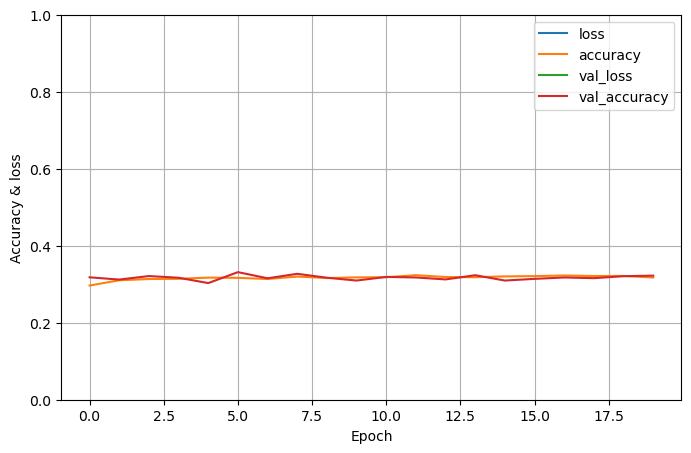

In [33]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.xlabel('Epoch')
plt.ylabel('Accuracy & loss')
plt.show()

In [34]:
# Évaluer la performance sur l'ensemble de test
loss, accuracy = model_cnn_multi.evaluate(X_test, y_test)

# Affichez les résultats
print(f"Loss on test set: {loss}")
print(f"Accuracy on test set: {accuracy}")

86/86 [==============================] - 1s 7ms/step - loss: 1.3213 - accuracy: 0.3299
Loss on test set: 1.3213378190994263
Accuracy on test set: 0.3299344480037689
